<a href="https://colab.research.google.com/github/rajashekarv95/Autoencoders/blob/master/Dimensionality_Reduction_Using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality reduction using Autoencoders
An intuitive way to understand Autoencoders


Importing required libraries

In [1]:
import numpy as np

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn import decomposition

Setting device to GPU if available

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Creating a synthetic dataset to demonstrate dimensionality reduction

In [3]:
np.random.seed(0)
torch.random.seed()
m = 1000
w1, w2 = 0.1, 0.3
noise = 0.1

angles = torch.rand(m, device=device) * 3 * np.pi / 2 - 0.5
data = torch.zeros((m, 3), device=device)
data[:, 0] = torch.cos(angles) + torch.sin(angles)/2 + noise * torch.randn(m, device=device) / 2
data[:, 1] = torch.sin(angles) * 0.7 + noise * torch.randn(m, device=device) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * torch.randn(m, device=device)

In [4]:
data

tensor([[-0.9724, -0.1522, -0.0168],
        [ 1.0459,  0.4200,  0.4336],
        [ 0.9152,  0.6118,  0.0930],
        ...,
        [-1.1722, -0.1725, -0.0283],
        [ 0.8488,  0.6447,  0.1821],
        [ 0.9796, -0.2073,  0.0326]], device='cuda:0')

In [5]:
#Taking first 900 samples as train set and the next 100 as test
X_train = data[:900,:]
X_test = data[900:,:]

#Normalizing the dataset
m = X_train.mean(0, keepdim=True)
s = X_train.std(0, unbiased=False, keepdim=True)
X_train -= m
X_train /= s

X_test -= m
X_test /= s

Obtaining the shape of the training set and setting the latent space dimension = 2

In [6]:
m, n_x = X_train.shape
n_latent = 2

Visualizing the 3-D dataset on a 3-D plot

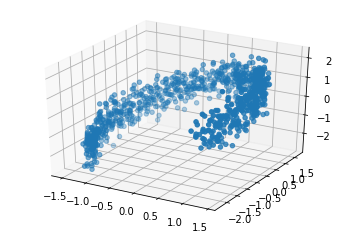

In [8]:
ax = plt.axes(projection='3d')
# ax.view_init(30, 35)
ax.scatter3D(X_train[:,0].cpu(), X_train[:,1].cpu(), X_train[:,2].cpu());

# Defining the autoencoder class. 
This is a simple autoencoder with just one hidden layer which represents the latent space of dimension n_latent. Note that I have used no activations here, which means that this is a linear autoencoder

In [9]:
class autoencoder(nn.Module):
    def __init__(self, n_x, n_latent):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_x, n_latent))
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, n_x))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Define dataloader, model, loss and optimizer

In [11]:
batch_size = 50
learning_rate = 0.01

dataloader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
model = autoencoder(n_x, n_latent).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the autoencoder for 100 epochs and print train and validation loss at each epoch

In [12]:
num_epochs = 100
loss_list = []
for epoch in range(num_epochs):
  for mini_batch in dataloader:
    #Forward
    output = model(mini_batch)

    #Loss
    loss = criterion(output, mini_batch)

    #Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Store loss for visualization
    loss_list.append(loss)

  output_validation = model(X_test)  
  loss_validation = criterion(output_validation, X_test)
  print('epoch [{}/{}], loss:{:.4f}, loss_validation:{:.4f}'
          .format(epoch + 1, num_epochs, loss, loss_validation))


epoch [1/100], loss:0.7104, loss_validation:0.7281
epoch [2/100], loss:0.3228, loss_validation:0.3770
epoch [3/100], loss:0.2267, loss_validation:0.2422
epoch [4/100], loss:0.1722, loss_validation:0.1679
epoch [5/100], loss:0.1682, loss_validation:0.1033
epoch [6/100], loss:0.0719, loss_validation:0.0686
epoch [7/100], loss:0.0557, loss_validation:0.0586
epoch [8/100], loss:0.0777, loss_validation:0.0555
epoch [9/100], loss:0.0744, loss_validation:0.0542
epoch [10/100], loss:0.0711, loss_validation:0.0540
epoch [11/100], loss:0.0478, loss_validation:0.0542
epoch [12/100], loss:0.0644, loss_validation:0.0552
epoch [13/100], loss:0.0553, loss_validation:0.0550
epoch [14/100], loss:0.0603, loss_validation:0.0548
epoch [15/100], loss:0.0446, loss_validation:0.0556
epoch [16/100], loss:0.0561, loss_validation:0.0549
epoch [17/100], loss:0.0605, loss_validation:0.0553
epoch [18/100], loss:0.0541, loss_validation:0.0554
epoch [19/100], loss:0.0579, loss_validation:0.0550
epoch [20/100], loss:

Visualize the loss curve

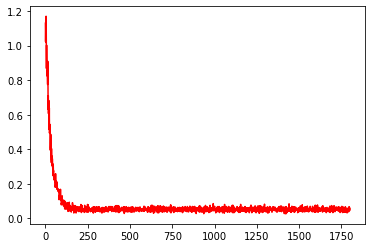

In [13]:
plt.plot(np.array(loss_list), 'r')

Visualize the encodings the training set. Notice that the dimension of the train data is reduced from 3 to 2. 

In [14]:
train_latent = model.encoder(X_train)
train_latent.shape

torch.Size([900, 2])

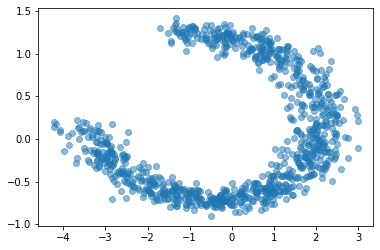

In [17]:
plt.scatter(train_latent[:,0].cpu().detach().numpy(), train_latent[:,1].cpu().detach().numpy(), alpha=0.5)

Do the same visualization on the test set

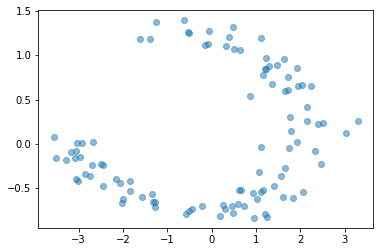

In [18]:
test_latent = model.encoder(X_test)
plt.scatter(test_latent[:,0].cpu().detach().numpy(), test_latent[:,1].cpu().detach().numpy(), alpha=0.5)

## Compare with PCA decomposition done with SKLearn
This is very similar in shape to the outputs of autoencoder. This is provides an intuitive understanding of what an autoencoder is doing under the hood. Note that I have just used a linear autoencoder here (without any non linear activation). This can be extended to learn more complex functions using a non linear activation.

In [21]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_train.cpu())
X = pca.transform(X_train.cpu())
X.shape

(900, 2)

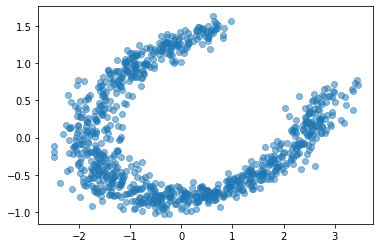

In [22]:
plt.scatter(X[:,0], X[:,1], alpha=0.5)